In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from img2vec_pytorch import Img2Vec
import os

# for reproducibility
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark=True

# Misc

In [3]:
import multiprocessing

import numpy as np

NUM_PROCESS = 2

def unpacking_apply_along_axis(all_args):
    (func1d, axis, arr, args, kwargs) = all_args
    
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)

def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """        
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, NUM_PROCESS)]
    
    # print(chunks)

    pool = multiprocessing.Pool(processes=NUM_PROCESS)
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    
    # Freeing the workers:
    pool.close()
    pool.join()
    
    # print(individual_results)

    return np.concatenate(individual_results)


# def unpacking_matrix_operation(all_args)
#     (func, sub_arr) = 

def parallel_matrix_operation(func, arr):
    # chunks = [(func, sub_arr) for sub_arr in np.array_split(arr, NUM_PROCESS)]
    chunks = np.array_split(arr, NUM_PROCESS)
    
    
    pool = multiprocessing.Pool(processes=NUM_PROCESS)
    individual_results = pool.map(func, chunks)
    
    # Freeing the workers:
    pool.close()
    pool.join()
    
    # print(individual_results)

    return np.concatenate(individual_results)

def tpr_tnr(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Negative)
    #   inf   where prediction is 1 and truth is 0 (False Negative)
    #   nan   where prediction and truth are 0 (True Positive)
    #   0     where prediction is 0 and truth is 1 (False Positive)
    
    true_negatives = torch.sum(confusion_vector == 1).item()
    false_negatives = torch.sum(confusion_vector == float('inf')).item()
    true_positives = torch.sum(torch.isnan(confusion_vector)).item()
    false_positives = torch.sum(confusion_vector == 0).item()

    # print(true_negatives, false_negatives, true_positives, false_positives)
    return true_positives / (true_positives + false_negatives), true_negatives / (true_negatives + false_positives), (true_positives + true_negatives) / (true_negatives + false_negatives + true_positives + false_positives)

# LDP

In [4]:
l = 20
m = 5
r = 512

def float_to_binary(x, m, n):
    x_abs = np.abs(x)
    x_scaled = round(x_abs * 2 ** n)
    res = '{:0{}b}'.format(x_scaled, m + n)
    if x >= 0:
        res = '0' + res
    else:
        res = '1' + res
    return res

# binary to float
def binary_to_float(bstr, m, n):
    sign = bstr[0]
    # print(int(sign))
    bs = bstr[1:]
    res = int(bs, 2) / 2 ** n
    if int(sign) == 49:
        res = -1 * res
    return res

def string_to_int(a):
    bit_str = "".join(x for x in a)
    return np.array(list(bit_str)).astype(int)


def join_string(a, num_bit=l, num_feat=r):
    res = np.empty(num_feat, dtype="S20")
    # res = []
    for i in range(num_feat):
        # res.append("".join(str(x) for x in a[i*l:(i+1)*l]))
        res[i] = "".join(str(x) for x in a[i*l:(i+1)*l])
    return res


def float_bin(x):
    return float_to_binary(x, m, l-m-1)
    

def bin_float(x):
    return binary_to_float(x, m, l-m-1)

In [5]:
def BitRand(sample_feature_arr, eps=20.0, l=5, m=m):

    r = sample_feature_arr.shape[1]
    
    float_to_binary_vec = np.vectorize(float_bin)
    binary_to_float_vec = np.vectorize(bin_float)

    feat_tmp = parallel_matrix_operation(float_to_binary_vec, sample_feature_arr)
    feat = parallel_apply_along_axis(string_to_int, axis=1, arr=feat_tmp)

    rl = r * l
    sum_ = 0
    for k in range(l):
        sum_ += np.exp(2 * eps*k /l)
    alpha = np.sqrt((eps + rl) /( 2*r *sum_ ))
    index_matrix = np.array(range(l))
    index_matrix = np.tile(index_matrix, (sample_feature_arr.shape[0], r))
    p =  1/(1+alpha * np.exp(index_matrix*eps/l) )
    p_temp = np.random.rand(p.shape[0], p.shape[1])
    perturb = (p_temp > p).astype(int)

    perturb_feat = (perturb + feat)%2
    perturb_feat = parallel_apply_along_axis(join_string, axis=1, arr=perturb_feat)
    # print(perturb_feat)
    return torch.tensor(parallel_matrix_operation(binary_to_float_vec, perturb_feat), dtype=torch.float)

def BitRand_1(sample_feature_arr, eps, l=20, m=5, r=512):
    float_bin_2 = lambda x: float_to_binary(x, m, l-m-1)
    float_to_binary_vec_2 = np.vectorize(float_bin_2)
    bin_float_2 = lambda x: binary_to_float(x, m, l-m-1)
    binary_to_float_vec_2 = np.vectorize(bin_float_2)

    feat_tmp = float_to_binary_vec_2(sample_feature_arr)
    feat = np.apply_along_axis(string_to_int, axis=1, arr=feat_tmp)
    sum_ = 0
    for k in range(l):
        sum_ += np.exp(2 * eps*k /l)
    alpha = np.sqrt((eps + r*l) /( 2*r *sum_ ))

    index_matrix = np.array(range(l))
    index_matrix = np.tile(index_matrix, (1, r))
    p =  1/(1+alpha * np.exp(index_matrix*eps/l) )
    p_temp = np.random.rand(p.shape[0], p.shape[1])
    perturb = (p_temp > p).astype(int)
    perturb_feat = (perturb + feat)%2
    perturb_feat = np.apply_along_axis(join_string, axis=1, arr=perturb_feat)
    perturb_feat = binary_to_float_vec_2(perturb_feat)
    return torch.squeeze(torch.tensor(perturb_feat, dtype=torch.float))#.cuda()

def OME(sample_feature_arr, eps=10.0, l=20, m=5):
    r = sample_feature_arr.shape[1]
    
    float_to_binary_vec = np.vectorize(float_bin)
    binary_to_float_vec = np.vectorize(bin_float)

    feat_tmp = parallel_matrix_operation(float_to_binary_vec, sample_feature_arr)
    feat = parallel_apply_along_axis(string_to_int, axis=1, arr=feat_tmp)

    rl = r * l
    alpha_ome = 100
    index_matrix_1 = np.array([alpha_ome / (1+ alpha_ome), 1/ (1+alpha_ome**3)]*int(l/2)) # np.array(range(l))
    index_matrix_0 = np.array([ (alpha_ome * np.exp(eps/rl)) /(1 + alpha_ome* np.exp(eps/rl))]*int(l) )
    p_1 = np.tile(index_matrix_1, (sample_feature_arr.shape[0], r))
    p_0 = np.tile(index_matrix_0, (sample_feature_arr.shape[0], r))

    p_temp = np.random.rand(p_0.shape[0], p_0.shape[1])
    perturb_0 = (p_temp > p_0).astype(int)
    perturb_1 = (p_temp > p_1).astype(int)

    perturb_feat = np.array(torch.where(torch.tensor(feat)>0, torch.tensor((perturb_1 + feat)%2), torch.tensor((perturb_0 + feat)%2)) )
    perturb_feat = parallel_apply_along_axis(join_string, axis=1, arr=perturb_feat)

    return torch.tensor(parallel_matrix_operation(binary_to_float_vec, perturb_feat), dtype=torch.float)


def OME_1(sample_feature_arr, eps=10.0, l=20, m=5):
    
    float_bin_2 = lambda x: float_to_binary(x, m, l-m-1)
    float_to_binary_vec_2 = np.vectorize(float_bin_2)
    bin_float_2 = lambda x: binary_to_float(x, m, l-m-1)
    binary_to_float_vec_2 = np.vectorize(bin_float_2)

    r = sample_feature_arr.shape[1]
    
    float_to_binary_vec = np.vectorize(float_bin)
    binary_to_float_vec = np.vectorize(bin_float)

    feat_tmp = float_to_binary_vec_2(sample_feature_arr)
    feat = np.apply_along_axis(string_to_int, axis=1, arr=feat_tmp)

    rl = r * l
    alpha_ome = 100
    index_matrix_1 = np.array([alpha_ome / (1+ alpha_ome), 1/ (1+alpha_ome**3)]*int(l/2)) # np.array(range(l))
    index_matrix_0 = np.array([ (alpha_ome * np.exp(eps/rl)) /(1 + alpha_ome* np.exp(eps/rl))]*int(l) )
    p_1 = np.tile(index_matrix_1, (sample_feature_arr.shape[0], r))
    p_0 = np.tile(index_matrix_0, (sample_feature_arr.shape[0], r))

    p_temp = np.random.rand(p_0.shape[0], p_0.shape[1])
    perturb_0 = (p_temp > p_0).astype(int)
    perturb_1 = (p_temp > p_1).astype(int)

    perturb_feat = np.array(torch.where(torch.tensor(feat)>0, torch.tensor((perturb_1 + feat)%2), torch.tensor((perturb_0 + feat)%2)) )
    perturb_feat = np.apply_along_axis(join_string, axis=1, arr=perturb_feat)

    perturb_feat = binary_to_float_vec_2(perturb_feat)
    return torch.squeeze(torch.tensor(perturb_feat, dtype=torch.float))#.cuda()

# Dataset

In [6]:
class AMIADatasetCifar10(Dataset):
    def __init__(self, target, transform, dataroot, train=True, imgroot=None, multiplier=100):
        self.target = target
        self.target_multiplier = multiplier
        self.transform = transform
        if train:
            # self.valid_data = np.arange(50000, 60000)
            self.valid_data = np.arange(50000)
            self.length = len(target) * multiplier + len(self.valid_data)
        else:
            # self.train_data = np.arange(50000)
            self.train_data = np.arange(50001, 60000)
            # mask = np.ones(50000, dtype=bool)
            # mask[target] = False
            # self.train_data = self.train_data[mask, ...]
            self.length = len(self.train_data) + len(target) * multiplier
        self.dataroot = dataroot
        self.imgroot = imgroot
        self.data_name = sorted(os.listdir(dataroot))
        self.train = train
            
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if self.train == False:
            if idx / self.target_multiplier < len(self.target):
                filename = self.data_name[self.target[ int(idx / self.target_multiplier) ]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.target[idx]])
                class_id = torch.tensor(int(idx / self.target_multiplier))                
            else:
                idx -= len(self.target) * self.target_multiplier
                filename = self.data_name[self.train_data[idx]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.valid_data[idx]])
                class_id = torch.tensor(len(self.target))
                
        else:
            if idx / self.target_multiplier < len(self.target):
                filename = self.data_name[self.target[ int(idx / self.target_multiplier) ]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.target[idx]])
                class_id = torch.tensor(int(idx / self.target_multiplier))                
            else:
                idx -= len(self.target) * self.target_multiplier
                filename = self.data_name[self.valid_data[idx]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.valid_data[idx]])
                class_id = torch.tensor(len(self.target))
            
        if self.imgroot:
            img = Image.open(self.imgroot + filename)
            img = self.transform(img)
        else:
            img = torch.tensor([])
        
        # img_tensor = img2vec.get_vec(img, tensor=True)
        # img_tensor = torch.squeeze(img_tensor)
        img_tensor = torch.load(self.dataroot + filename)
        
        # img_tensor = img_tensor + s1.astype(np.float32)
        
        return img_tensor, class_id, img

In [7]:
VEC_PATH='../data/cifar10_vec/'

num_target = 1
target = [50000]
mech_setting = 'BitRand'
eps = 6

if mech_setting == 'BitRand':
    mech = BitRand
    mech_1 = BitRand_1
elif mech_setting == 'OME':
    mech = OME
    mech_1 = OME_1
else:
    print('Error mech')
    exit()

print('Loading data...')
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

test_loader = torch.utils.data.DataLoader(AMIADatasetCifar10(target, transform, VEC_PATH, False, imgroot=None, multiplier=1), shuffle=False, num_workers=0, batch_size=200000)

x_test, y_test, _ = next(iter(test_loader))

Loading data...


# Adversary

In [8]:
class Classifier(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 2*n_inputs)
        self.fc2 = nn.Linear(2*n_inputs, 1)
        
    def adv_weights(self, target, tau, delta = 0):
        K = torch.eye(self.fc1.in_features)
        K = torch.cat((K, -K), 0)
        self.fc1.weight.data = K
        self.fc1.bias.data = torch.cat((-target - delta, target - delta), 0)
        
        self.fc2.weight.data[0] = -torch.ones(self.fc2.in_features)
        self.fc2.bias.data[0] = tau
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        fc2 = self.fc2(x)
        x = F.relu(fc2)
        return x, fc2
    
model = Classifier(x_test.shape[1], num_target + 1)
model.adv_weights(x_test[0], 0.0, 0.0)

model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

# Setup security game

In [9]:
D = 100 # batch size
times = 200 # num of runs
NUM_PROCESS = 8
from tqdm import tqdm

def task_tpr(i):
    x_test_threat = torch.cat((x_test[:1], x_test[np.random.randint(1, x_test.shape[0], D-1)]))
    x_test_threat = BitRand_1(x_test_threat, eps, l=l, m=m)
#     x_test_threat = OME_1(x_test_threat, eps, l=l, m=m) # Uncomment for OME
    return x_test_threat

def task_tnr(i):
    x_test_threat = x_test[np.random.randint(1, x_test.shape[0], D)]
    x_test_threat = BitRand_1(x_test_threat, eps, l=l, m=m)
#     x_test_threat = OME_1(x_test_threat, eps, l=l, m=m) # Uncomment for OME
    return x_test_threat

# Find Tau

In [10]:
D = 64 # batch size
times = 100 # num of runs
NUM_PROCESS = 8

model = Classifier(x_test.shape[1], num_target + 1)
model.adv_weights(x_test[0], 0.0)

model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

# eps_taus = range(1,10) # to reproduce
eps_taus = range(5,7) # to test
taus = []
for eps_tau in eps_taus:
    
    eps = eps_tau
    with multiprocessing.Pool(processes=NUM_PROCESS) as pool:
        x_tpr = list(tqdm(pool.imap_unordered(task_tpr, range(times), chunksize=5), total=times))
        x_tnr = list(tqdm(pool.imap_unordered(task_tnr, range(times), chunksize=5), total=times))
    
    tmp_tau = 0
    for x in tqdm(x_tpr):
        out = model(x)[1]
        out_pattern = out[0]
        out_base = torch.mean(out[1:])
        tmp_tau = tmp_tau + (out_pattern + out_base)/2 
    tmp_tau = tmp_tau/len(x_tpr)
    taus.append(tmp_tau)  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.23it/s]


# Attack

In [11]:
import pandas as pd
import pickle 
log_filename = 'FC_AMI_LDP_CIFAR10.pkl'

result_log = pd.DataFrame() 

In [12]:
D = 64 # batch size
# runs = 20 # to reproduce 
runs = 1
# games = 250 # to reproduce

games = 100
times = runs*games
NUM_PROCESS = 8

advs = []
tprs = []
tnrs = []

for i in range(len(eps_taus)):
    
    eps = eps_taus[i]
    model = Classifier(x_test.shape[1], num_target + 1)
    model.adv_weights(x_test[0], -taus[i].detach(), 0.0) # Set tau in the FC-based adversary. If use OME, it should be ~ 400

    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
    
    
    with multiprocessing.Pool(processes=NUM_PROCESS) as pool:
        x_tpr = list(tqdm(pool.imap_unordered(task_tpr, range(times), chunksize=5), total=times))
        x_tnr = list(tqdm(pool.imap_unordered(task_tnr, range(times), chunksize=5), total=times))

    
    tpr = []
    for x in tqdm(x_tpr):
        out = model(x)[0]
        if torch.sum(out > 0) > 0:
            tpr.append(1)
        else:
            tpr.append(0)

    tnr = []
    for x in tqdm(x_tnr):
        out = model(x)[0]
        if torch.sum(out > 0) == 0:
            tnr.append(1)
        else:
            tnr.append(0)
    
    for i in range(runs):
        start_index = i*games
        end_index = (i+1)*games

        tp = sum(tpr[start_index:end_index])/games
        tn = sum(tnr[start_index:end_index])/games
        adv = tp/2 + tn/2
        
        report = {'eps' : eps,
                'adv': adv}
        
        result_log = pd.concat([result_log, pd.DataFrame.from_records([report])])
        with open(log_filename, 'wb') as logfile:
            pickle.dump(result_log, logfile)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.39it/s]


In [13]:
result_log

,eps,adv
0,5,0.92
0,6,1.00


# Simulate Theory

In [20]:
import pandas as pd
import pickle as pickle


def find_delta_X(target, data):
    min_dist = 500000
    for i in range(data.shape[0]):
        dist = sum(abs(target - data[i]))
        if dist < min_dist:
            min_dist = dist
    return 1/2*min_dist

target = x_test[0].clone()
min_dist = find_delta_X(target, x_test[1:])

run_id = '999'
dataset = 'CIFAR10'
output_path = ''    
    
log_filename = os.path.join(output_path, "log_{}_{}.pkl".format(dataset, run_id))

if os.path.isfile(log_filename):
    sim_log = pd.read_pickle(log_filename)
else:
    sim_log = pd.DataFrame() 

no_runs = 50
N = 100

for _ in range(no_runs):

    Pm = []
    for eps in range(8,12):

        dup = target.repeat([N,1])
        ldp_dup = BitRand(dup, eps, l=l, m=m)


        ldp_dist = []
        for i in range(N):
            dist = sum(abs(target - ldp_dup[i]))
            if dist > min_dist:
                ldp_dist.append(1)
            else:
                ldp_dist.append(0)
                
        Pm.append(np.sum(np.asarray(ldp_dist))/N)
    
        result = {'Run ID': run_id,
                  'Dataset': dataset,
                  'Prob' : np.sum(np.asarray(ldp_dist))/N,
                  'Eps': eps}
        
        sim_log = pd.concat([sim_log, pd.DataFrame.from_records([result])])
#         with open(log_filename, 'wb') as logfile:
#             pickle.dump(training_log, logfile)

<AxesSubplot: xlabel='Eps', ylabel='Success rate'>

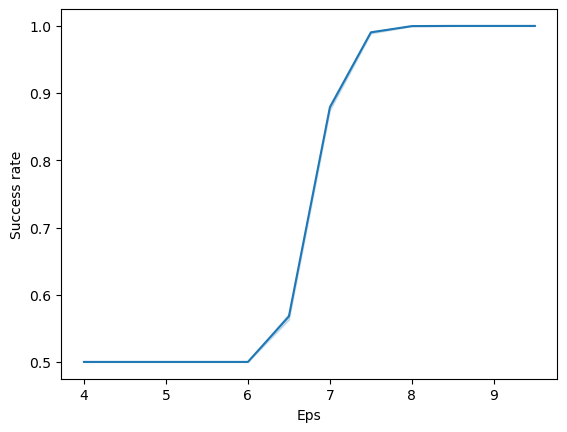

In [19]:
import seaborn as sns

# sim_log = pd.read_pickle('log_training_CIFAR10_9.pkl')
D = 100
size_X = 1000
sim_log['Success min'] =  0.5
sim_log['Success rate'] =  (2 - sim_log['Prob']*(D + size_X)/size_X)/2
sim_log['Success rate'] = sim_log[['Success rate', 'Success min']].max(axis=1)

sns.lineplot( x="Eps", y="Success rate", 
                     data=sim_log, 
                     palette = 'tab10',
                     markers=True,
                     legend=True)